* https://towardsdatascience.com/transformers-141e32e69591
* https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
* https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9#:~:text=LSTMs%20use%20a%20series%20of,each%20their%20own%20neural%20network.
* https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well
* https://www.youtube.com/watch?v=ROLugVqjf00
* https://lilianweng.github.io/posts/2019-03-14-overfit/    (very important)
* https://atcold.github.io/pytorch-Deep-Learning/en/week11/11-3/

In [1]:
NR_OF_PIXELS= 20
BACKWARD_WINDOW_LENGTH = 19
FORWARD_WINDOW_LENGTH = 2

# LIBRARIES

In [2]:
import MetaTrader5 as mt5

import pandas as pd

from datetime import datetime

import pytz

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import entropy
from scipy.stats import ks_2samp

import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer

import pyspark
from pyspark.sql import SparkSession

from IPython import display

import time

# CONFIG

In [3]:
pd.set_option('display.float_format', '{:.5f}'.format)

In [4]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2022, 8, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2022, 11, 1, tzinfo=gc_o_TIME_ZONE)

In [5]:
sCategory = 'Stocks\\Germany\\Banking & Investment Services\\Banks\\'

# SOURCE DATA

In [6]:
def dfFetchSampleDataFromMt(p_sSymbolName):
    aOhlSample = mt5.copy_rates_range(
        p_sSymbolName,
        mt5.TIMEFRAME_M1,
        gc_dt_FROM, 
        gc_dt_TO
    )

    dfToReturn = pd.DataFrame(aOhlSample)
    if 'time' in list(dfToReturn.columns):
        return dfToReturn
    else:
        return dfFetchSampleDataFromMt(p_sSymbolName)
    
    

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
tplSymbols = mt5.symbols_get()
dfSymbols = pd.DataFrame(tplSymbols, columns = tplSymbols[0]._asdict().keys())


def aGetUniqueCategories(tplSymbols):
    aCategories = []
    for i in range(0, len(tplSymbols)):
        sCategory = '\\'.join(tplSymbols[i]._asdict()['path'].split('\\')[:-1]) +'\\'
        if sCategory not in aCategories:
            aCategories.append(sCategory)
    return aCategories


aCategories = aGetUniqueCategories(tplSymbols)


dfFilteredSymbols = dfSymbols[dfSymbols['path'].str.contains(sCategory, regex=False) == True]

dfOhlc = pd.DataFrame()

for iIndex, srsRow in dfFilteredSymbols.iterrows():
    sSymbolName = dfFilteredSymbols.loc[iIndex, 'name']
    iDigit  = dfFilteredSymbols.loc[iIndex, 'digits']
    
    dfOhlcSample =  dfFetchSampleDataFromMt(sSymbolName)
    
    if len(dfOhlcSample) > 500:
        dfOhlcSample['EXCHANGE_RATE'] =  sSymbolName
        dfOhlcSample['DIGIT_SENSITIVITY'] =  iDigit
        dfOhlc = dfOhlc.append(dfOhlcSample)
        
dfOhlc.reset_index(drop = True, inplace = True)

In [7]:
dfOhlc['time'] = pd.to_datetime(dfOhlc['time'], unit = 's')

# PREPROCESS

In [8]:
dfPrep = dfOhlc.copy()

## Add Last Digits

In [9]:
# To-be-continued

## Add Candlestick Features

In [10]:
dfPrep['RETURN'] =  (dfPrep['close']-dfPrep['open'])/dfPrep['open']

dfPrep["UPPER_SHADOW"] =( dfPrep["high"] - dfPrep[['close', 'open']].max(axis=1))/ dfPrep[['close', 'open']].max(axis=1)
dfPrep["LOWER_SHADOW"] = (dfPrep[['close', 'open']].min(axis=1) - dfPrep["low"])/dfPrep["low"]

## Add Seasonal Features

In [11]:
dfPrep.loc[:, 'MINUTE'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.minute
dfPrep.loc[:, 'HOUR'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.hour
dfPrep.loc[:, 'DAY_OF_WEEK'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.day_of_week
dfPrep.loc[:, 'DAY_OF_MONTH'] = pd.to_datetime(dfPrep.loc[:, 'time'],unit='s').dt.day

## Select Only One Exchange Rate

In [12]:
# dfPrep.query('EXCHANGE_RATE == "CBKG.DE"', inplace  = True)

## Calculate Support and Resistence Levels

K-Means Algorithm used to identify the support and resistence levels.
* https://medium.com/@judopro/using-machine-learning-to-programmatically-determine-stock-support-and-resistance-levels-9bb70777cf8e

In [13]:
# def bIsSupport(df, l, n1, n2):
#     for i in range(l-n1+1, l+1):
#         if (df['low'].iloc[i] > df['low'].iloc[i-1]):
#             return 0
        
#     for i in range(l+1, l+n2+1):
#         if (df['low'].iloc[i] < df['low'].iloc[i-1] ):
#             return 0
        
#     return 1


# def bIsResistence(df, l, n1, n2):
#     for i in range(l-n1+1, l+1):
#         if (df['high'].iloc[i] > df['high'].iloc[i-1]):
#             return 0
        
#     for i in range(l+1, l+n2+1):
#         if (df['high'].iloc[i] < df['high'].iloc[i-1] ):
#             return 0
        
#     return 1



# n1 = 4
# n2 = 4
# for i in range(0, len(dfPrep)):
#     dfPrep.iloc[i].loc['IS_SUPPORT'] = bIsSupport(dfPrep, i, n1, n2)
#     dfPrep.iloc[i].loc['IS_RESISTENCE'] = bIsResistence(dfPrep, i, n1, n2)



# FEATURE ENGINEERING

In [14]:

def GET_DATASETS_1(dfPreprocessed):

    dfPreprocessed.sort_values(by = ['EXCHANGE_RATE', 'time'], inplace = True)

    # prepare input dataset
    dfX = dfPreprocessed[['RETURN', 'UPPER_SHADOW', 'LOWER_SHADOW']].copy()

    df = pd.DataFrame(index = dfX.index)

    for i in range(-BACKWARD_WINDOW_LENGTH, 0):
        df = df.merge(right  =dfX.shift(-i).add_prefix('{}|'.format(i)), left_index= True, right_index = True)


    # add seasonal features to input dataset
    df = df.merge(right = dfPreprocessed[['MINUTE', 'HOUR', 'DAY_OF_WEEK','DAY_OF_MONTH']],left_index = True, right_index =True, how = 'inner') 

    # drop due to transition from one exchange to another
    ixToDrop = dfPreprocessed[['EXCHANGE_RATE']].merge(right = dfPreprocessed[['EXCHANGE_RATE']].shift(BACKWARD_WINDOW_LENGTH), left_index  = True, right_index = True, how = 'inner').query('EXCHANGE_RATE_x != EXCHANGE_RATE_y').index
    df.drop(ixToDrop, inplace = True)

    dfX = df

    # prepare output dataset
    dfY = dfPreprocessed[['RETURN']].copy()

    df = pd.DataFrame(index = dfY.index)

    for i in range(0, FORWARD_WINDOW_LENGTH):
        df = df.merge(right  =dfY.shift(-i).add_prefix('{}|'.format(i)), left_index= True, right_index = True)

    ixToDrop = dfPreprocessed[['EXCHANGE_RATE']].merge(right = dfPreprocessed[['EXCHANGE_RATE']].shift(-FORWARD_WINDOW_LENGTH), left_index  = True, right_index = True, how = 'inner').query('EXCHANGE_RATE_x != EXCHANGE_RATE_y').index
    df.drop(ixToDrop, inplace = True)

    dfY = df

    # drop records that contain at least one nan
    ixToDrop = list(dfX[dfX.isna().any(axis = 1)].index) + list(dfY[dfY.isna().any(axis = 1)].index) 
    dfX.drop(ixToDrop, inplace = True)
    dfY.drop(ixToDrop, inplace = True)

    
    # use common timestamps
    ixCommon = np.intersect1d(dfX.index, dfY.index)
    dfX = dfX.loc[ixCommon]
    dfY = dfY.loc[ixCommon]
    
    return dfX, dfY


def GET_DATASETS_2(dfPreprocessed):

    #Create PySpark SparkSession
    oSparkSess = SparkSession.builder \
        .master("local[1]") \
        .appName("SparkByExamples.com") \
        .getOrCreate()

    oSparkSess.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

    def dfGetPixels(df, iFrom, iTo):
        df['from_time'] = df['time'] + pd.DateOffset(hours=iFrom)
        df['to_time'] = df['time'] + pd.DateOffset(hours=iTo)


        df = df[['to_time', 'from_time', 'time','close']]


        sdf= oSparkSess.createDataFrame(df)
        sdf.createOrReplaceTempView("sdf")

        dfPriceAnalysis = oSparkSess.sql("""
            SELECT 
                t.from_time, 
                t.to_time,
                t.time, 
                t.close, 
                t.HISTORICAL_CLOSE, 
                count(*) AS NR_OF_MINS
            FROM
            (
                SELECT df1.*, df2.close as HISTORICAL_CLOSE FROM sdf df1
                INNER JOIN sdf df2
                ON df2.time >= df1.from_time and df2.time < df1.to_time
            ) t
            GROUP BY t.from_time, t.to_time, t.time, t.close, t.HISTORICAL_CLOSE
            ORDER BY t.from_time, t.to_time, t.time, t.close, t.HISTORICAL_CLOSE
        """).toPandas()

        df.set_index(['time', 'close'], inplace = True)
        dfToReturn = pd.DataFrame(
            data =  np.zeros((len(df) , NR_OF_PIXELS)).astype(int), 
            columns = list(range(0,NR_OF_PIXELS)),
            index = df.index
        )


        if len(dfPriceAnalysis)==0:
            return dfToReturn
        else:
            dfPriceAnalysis.sort_values(['time', 'HISTORICAL_CLOSE'], inplace = True)
            dfPriceAnalysis.loc[:, 'DIFF'] =  dfPriceAnalysis.loc[: , 'HISTORICAL_CLOSE']-dfPriceAnalysis.loc[:, 'close']
            oDiscretizer = KBinsDiscretizer(n_bins=NR_OF_PIXELS, encode='ordinal', strategy='quantile')

            dfSample = pd.DataFrame(
                data = np.arange(-0.10, 0.10 , (0.20/NR_OF_PIXELS)),
                columns = ['DIFF']
            )
            oDiscretizer.fit(dfSample)
            dfPriceAnalysis['DIFF_BIN'] =  oDiscretizer.transform(dfPriceAnalysis[['DIFF']]).astype(int)
            dfPixel = dfPriceAnalysis.pivot_table(index = ['time', 'close'], columns = 'DIFF_BIN', values = 'NR_OF_MINS', aggfunc = 'sum', fill_value = 0)

            dfToReturn.loc[dfPixel.index] = dfPixel.values

            return dfToReturn


    df = dfPreprocessed.copy()

    # build input dataset
    X = []
    for i in range(-BACKWARD_WINDOW_LENGTH, 0):
        iFrom = i
        iTo = i +1

        print(iFrom)
        dfPixel = dfGetPixels(df, iFrom, iTo)
        dfPixel= dfPixel[BACKWARD_WINDOW_LENGTH * 60:]
        dfPixel= dfPixel[:-FORWARD_WINDOW_LENGTH * 60]

        if len(X) == 0:
            X = dfPixel.values
        else:
            X = np.append(X, dfPixel.values, axis = 1)

    X = X.reshape((-1, BACKWARD_WINDOW_LENGTH, dfPixel.shape[1]))

    # build output dataset
    Y = []
    for i in range(0, FORWARD_WINDOW_LENGTH):
        iFrom = i
        iTo = i +1

        print(iFrom)
        dfPixel = dfGetPixels(df, iFrom, iTo)

        dfPixel= dfPixel[BACKWARD_WINDOW_LENGTH * 60:]
        dfPixel= dfPixel[:-FORWARD_WINDOW_LENGTH * 60]

        if len(Y) == 0:
            Y = dfPixel.values
        else:
            Y = np.append(Y, dfPixel.values, axis = 1)

    Y = Y.reshape((-1, FORWARD_WINDOW_LENGTH, dfPixel.shape[1]))

    # reshape the image in following format (batch_size, NR_OF_PIXELS, TIME_STEP)
    X = np.transpose(X, (0,2,1))
    Y = np.transpose(Y, (0,2,1))

    # # divide all the minutes to 60 to normalize between 0-1 (1hr contains maximum 60 1m candlesticks)
    X = X/60
    Y = Y/60

    df= df.iloc[BACKWARD_WINDOW_LENGTH * 60:]
    df= df.iloc[:-FORWARD_WINDOW_LENGTH * 60]
    
    return X, Y, df

# DEMO BASELINE

In [15]:
# dfX, dfY = GET_DATASETS_1(dfPrep)

# # # independent component analysis
# # df = dfX.copy()
# # oIca = FastICA(n_components=7, random_state=0, whiten='unit-variance')

# # df = pd.DataFrame(
# #     data = oIca.fit_transform(df),
# #     index = df.index
# # )
# # df = df.add_prefix('ICA_')
# # dfX = df

# # # remove outliers from X
# # ixOutliers = dfX[(((dfX-dfX.mean())/dfX.std()).abs() > 3 ).any(axis = 1) == True].index
# # dfX.drop(ixOutliers, inplace = True)

# # # remove outliers from Y
# # ixOutliers = dfY[(((dfY-dfY.mean())/dfY.std()).abs() > 3 ).any(axis = 1) == True].index
# # dfY.drop(ixOutliers, inplace = True)



# # standarize input
# oScalerInput = StandardScaler()
# df =  dfX.copy()

# df = pd.DataFrame(
#     data = oScalerInput.fit_transform(df),
#     columns =  df.columns,
#     index = df.index
# )

# dfX = df.copy()


# # standardize output
# oScalerOutput = StandardScaler()
# df =  dfY.copy()

# df = pd.DataFrame(
#     data = oScalerOutput.fit_transform(df),
#     columns =  df.columns,
#     index = df.index
# )

# dfY = df.copy()


# # # PCA input
# # oPca = PCA(0.90)
# # df = dfX.copy()

# # df = pd.DataFrame(
# #     data = oPca.fit_transform(df),
# #     index = df.index
# # )
# # df = df.add_prefix('PCA_')
# # dfX = df.copy()


# # split data to train-validation-test

# c_fTrainingRatio = 0.70
# c_fValidationRatio = 0.28
# c_fTestRatio = 0.02

# ixTrain,ixTest = train_test_split(
#     dfX.index,
#     test_size=1-c_fTrainingRatio,
#     shuffle=False,
#     random_state = 1
# )

# ixValidation,ixTest= train_test_split(
#     ixTest,
#     test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
#     shuffle=False,
#     random_state = 1
# )


# dfX_train = dfX.loc[ixTrain]
# dfX_validation = dfX.loc[ixValidation]
# dfX_test = dfX.loc[ixTest]

# dfY_train = dfY.loc[ixTrain]
# dfY_validation = dfY.loc[ixValidation]
# dfY_test = dfY.loc[ixTest]


# # check identicality of distributions
# df = dfX.copy()
# dfDistAnalysis = pd.DataFrame(columns = ['FEATURE', 'TRAIN_VAL', 'TRAIN_TEST', 'VAL_TEST'])
# for sCol in df.columns:
#     # The null hypothesis is that the two distributions are identical
#     # If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.
#     fStatsTrainVal, fPValueTrainVal = ks_2samp(
#         df.loc[ixTrain, sCol],
#         df.loc[ixValidation, sCol]
#     )

#     fStatsTrainTest, fPValueTrainTest = ks_2samp(
#         df.loc[ixTrain, sCol],
#         df.loc[ixTest, sCol]
#     )

#     fStatsValTest, fPValueValTest = ks_2samp(
#         df.loc[ixValidation, sCol],
#         df.loc[ixTest, sCol]
#     )
    
#     dfDistAnalysis = pd.concat(
#          [dfDistAnalysis,
#          pd.DataFrame(data = [[sCol, fPValueTrainVal,  fPValueTrainTest, fPValueValTest]], columns = dfDistAnalysis.columns)
#          ],
#         ignore_index=False
#     )

# print('identicality of distributions: \n\n {}'.format(dfDistAnalysis))



# # model development
# X_train = dfX_train.values
# X_validation = dfX_validation.values
# X_test = dfX_test.values


# Y_train = dfY_train.values
# Y_validation = dfY_validation.values
# Y_test = dfY_test.values


# # compile model
# aInput = tf.keras.Input(
#     shape =  X_train.shape[1]
# )

# aHidden1 = tf.keras.layers.Dense(
#     units = 300, 
#     kernel_initializer='normal',
#     # activity_regularizer = tf.keras.regularizers.L2(0.1),
#     use_bias = False
# )(aInput)

# aHidden1 = tf.keras.layers.BatchNormalization()(aHidden1)
# aHidden1 = tf.keras.layers.ReLU()(aHidden1)
# # aHidden1 = tf.keras.layers.Dropout(0.5)(aHidden1)


# aHidden2 = aHidden1
# # aHidden2 = tf.keras.layers.Dense(
# #     units = 300, 
# #      kernel_initializer='normal',
# #     activity_regularizer = tf.keras.regularizers.L2(0.1),  
# #     use_bias = False
# # )(aHidden1)

# # aHidden2 = tf.keras.layers.BatchNormalization()(aHidden2)
# # aHidden2 = tf.keras.layers.ReLU()(aHidden2)
# # aHidden2 = tf.keras.layers.Dropout(0.5)(aHidden2)

# aOutput = tf.keras.layers.Dense(
#     units = Y_train.shape[1],
#     kernel_initializer='normal',
#     # activation = 'ReLU'
# )(aHidden2)

# oModel = tf.keras.Model(inputs=aInput, outputs=aOutput)

# oLearningRateSchedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = 1e-03 * 2,
#     decay_steps=100000,
#     decay_rate=1e-02,
#     staircase=True)


# oOptimizer = tf.keras.optimizers.Adam(learning_rate=oLearningRateSchedule)

# oModel.compile(optimizer=oOptimizer,loss= tf.keras.losses.MeanSquaredError())

# tf.keras.utils.plot_model(oModel, show_shapes=True)

# print(oModel.summary())


# # fit model
# oEarlyStop = tf.keras.callbacks.EarlyStopping(
#     monitor = 'val_loss', 
#     mode = 'min', 
#     verbose = 0 , 
#     patience = 50, 
#     restore_best_weights = True)

# oModel.fit(
#     X_train, 
#     Y_train, 
#     epochs= 1000, 
#     batch_size=2**5, 
#     verbose=0, 
#     validation_data= (X_validation, Y_validation),
#     # callbacks=[oEarlyStop]
# )


# # show epoch history
# dfHistory = pd.DataFrame(oModel.history.history)

# plt.figure(figsize = (20, 8))
# sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
# sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
# plt.show()


# # test model
# a_Y_datasets = [Y_train, Y_validation]
# a_X_datasets = [X_train, X_validation]
# a_labels = ['train', 'validation'] 

# plt.figure(figsize = (20,8 ))
# for X,Y, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
#     aActual = oScalerOutput.inverse_transform(Y)
#     aPred = oScalerOutput.inverse_transform(oModel.predict(X))

#     df = pd.DataFrame(data = np.column_stack((aActual,aPred)),
#                  columns = ['ACTUAL', 'PREDICTION']
#                 )
    
#     fR2Score = round(r2_score(aActual, aPred), 1)
#     sLabel = '{}   r2: {}'.format(sLabel,fR2Score)
#     sns.scatterplot(data = df, x = 'ACTUAL', y = 'PREDICTION', label = sLabel)
# plt.show()

# DEMO PIX-2-PIX

In [16]:
# # define the discriminator model
# def define_discriminator(image_shape = Y[0].shape):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # source image input
#     in_src_image = tf.keras.layers.Input(shape=image_shape)
#     # target image input
#     in_target_image = tf.keras.layers.Input(shape=image_shape)
    
    
#     # concatenate images channel-wise
#     merged = tf.keras.layers.Concatenate()([in_src_image, in_target_image])
#     # C64
#     d = tf.keras.layers.Conv1D(64, 1, strides=1, padding='same', kernel_initializer=init)(merged)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C128
#     d = tf.keras.layers.Conv1D(128, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C256
#     d = tf.keras.layers.Conv1D(256, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # C512
#     d = tf.keras.layers.Conv1D(512, 1, strides=1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # second last output layer
#     d = tf.keras.layers.Conv1D(512, 1, padding='same', kernel_initializer=init)(d)
#     d = tf.keras.layers.BatchNormalization()(d)
#     d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
#     # patch output
#     d = tf.keras.layers.Conv1D(1, 1, padding='same', kernel_initializer=init)(d)
#     patch_out = tf.keras.layers.Activation('sigmoid')(d)
#     # define model
#     model = tf.keras.Model([in_src_image, in_target_image], patch_out, name = 'DISCRIMINATOR_MODEL')

#     return model


# def discriminator_loss(disc_real_output, disc_generated_output):
#     loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
#     real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

#     generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

#     total_disc_loss = real_loss + generated_loss

#     return total_disc_loss


# # define an encoder block
# def define_encoder_block(layer_in, n_filters, batchnorm=True):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # add downsampling layer
#     g = tf.keras.layers.Conv1D(n_filters, 1, strides=1, padding='same', kernel_initializer=init)(layer_in)
#     # conditionally add batch normalization
#     if batchnorm:
#         g = tf.keras.layers.BatchNormalization()(g, training=True)
#     # leaky relu activation
#     g = tf.keras.layers.LeakyReLU(alpha=0.2)(g)
#     return g

# # define a decoder block
# def decoder_block(layer_in, skip_in, n_filters, dropout=True):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # add upsampling layer
#     g = tf.keras.layers.Convolution1DTranspose(n_filters, 1, strides=1, padding='same', kernel_initializer=init)(layer_in)
#     # add batch normalization
#     g = tf.keras.layers.BatchNormalization()(g, training=True)
#     # conditionally add dropout
#     if dropout:
#         g = tf.keras.layers.Dropout(0.5)(g, training=True)
#     # merge with skip connection
#     g = tf.keras.layers.Concatenate()([g, skip_in])
#     # relu activation
#     g = tf.keras.layers.Activation('relu')(g)
#     return g


# # define the standalone generator model
# def define_generator(image_shape=X[0].shape):
#     # weight initialization
#     init = tf.keras.initializers.RandomNormal(stddev=0.02)
#     # image input
#     in_image = tf.keras.layers.Input(shape=image_shape)
#     # encoder model
    
#     e1 = define_encoder_block(in_image, 64, batchnorm=False)
#     e2 = define_encoder_block(e1, 128)
#     e3 = define_encoder_block(e2, 256)
#     e4 = define_encoder_block(e3, 512)
#     e5 = define_encoder_block(e4, 512)
#     e6 = define_encoder_block(e5, 512)
#     e7 = define_encoder_block(e6, 512)

    
#     # bottleneck, no batch norm and relu
#     b = tf.keras.layers.Conv1D(512, 1, strides=1, padding='same', kernel_initializer=init)(e7)
#     b = tf.keras.layers.Activation('relu')(b)
    
#     # decoder model
#     d1 = decoder_block(b, e7, 512)
#     d2 = decoder_block(d1, e6, 512)
#     d3 = decoder_block(d2, e5, 512)
#     d4 = decoder_block(d3, e4, 512, dropout=False)
#     d5 = decoder_block(d4, e3, 256, dropout=False)
#     d6 = decoder_block(d5, e2, 128, dropout=False)
#     d7 = decoder_block(d6, e1, 64, dropout=False)
    
    
#     # output
#     g = tf.keras.layers.Conv1DTranspose(FORWARD_WINDOW_LENGTH, 1, strides=1, padding='same', kernel_initializer=init)(d7)
#     out_image = tf.keras.layers.Activation('tanh')(g)
#     # define model
#     model = tf.keras.Model(in_image, out_image, name = 'GENERATOR_MODEL')
#     return model


# def generator_loss(disc_generated_output, gen_output, target):
#     loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
#     gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#     # Mean absolute error
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

#     total_gen_loss = gan_loss + (LAMBDA * l1_loss)

#     return total_gen_loss, gan_loss, l1_loss


# oDiscriminator = define_discriminator()

# oGenerator = define_generator()

# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
# @tf.function
# def train_step(input_image, target, step):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = oGenerator(input_image, training=True)
        
#         # disc_real_output is not so much applicable for exchange rate prediction.
#         # because, in image recognition, templates of both input and target should match.
#         # in time series, template of backward and forward should be different.
#         # due to this reason, we should either generate different type of loss function.
#         # or we should use GAN for another purpose than pix2pix.
#         disc_real_output = oDiscriminator([input_image, target], training=True)
#         disc_generated_output = oDiscriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#         disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#         generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
#         discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#         discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

#         with summary_writer.as_default():
#             tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#             tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#             tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#             tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

            
# def generate_images(model, test_input, tar):
#     prediction = model(test_input, training=True)
    

#     display_list = [test_input[0], tar[0], prediction[0]]
#     title = ['Input Image', 'Ground Truth', 'Predicted Image']

#     for i in range(3):
#         plt.figure(figsize=(15, 15))
#         plt.subplot(1, 3, i+1)
#         plt.title(title[i])
#         # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
#         plt.show()

            
            
# X, Y = GET_DATASETS_2(dfPrep)
# # split data to train-validation-test
# c_fTrainingRatio = 0.70
# c_fValidationRatio = 0.28
# c_fTestRatio = 0.02

# X_train,X_test, Y_train, Y_test = train_test_split(
#     X,Y,
#     test_size=1-c_fTrainingRatio,
#     shuffle=False,
#     random_state = 1
# )

# X_validation, X_test,Y_validation, Y_test= train_test_split(
#     X_test,Y_test,
#     test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
#     shuffle=False,
#     random_state = 1
# )



# BATCH_SIZE = 50

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# validation_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))

# example_input, example_target = next(iter(validation_ds.take(1)))
# example_input = tf.expand_dims(example_input, axis = 0)            
# example_target = tf.expand_dims(example_target, axis = 0)   


# start = time.time()

# i = 0
# for (input_image, target) in train_ds.batch(BATCH_SIZE):

#     if (i) % 1000 == 0:
#         display.clear_output(wait=True)

#         if i != 0:
#             print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#         start = time.time()
        
#         generate_images(oGenerator, example_input, example_target)
#         print(f"Step: {i//1000}k")

#     # input_image = tf.expand_dims(input_image, axis = 0)            
#     # target = tf.expand_dims(target, axis = 0)           
    
#     train_step(input_image, target, i)

#     # Training step
#     if (i+1) % 10 == 0:
#         print('.', end='', flush=True)
    
#     i = i +1



# SEQ-2-SEQ

In [17]:
df = dfPrep.query('EXCHANGE_RATE == "DBKGn.DE"')
df.query('time >= "2022-10-15"', inplace = True)

X, Y, df = GET_DATASETS_2(df)

# split data to train-validation-test
c_fTrainingRatio = 0.70
c_fValidationRatio = 0.28
c_fTestRatio = 0.02

X_train,X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=1-c_fTrainingRatio,
    shuffle=False,
    random_state = 1
)

X_validation, X_test,Y_validation, Y_test= train_test_split(
    X_test,Y_test,
    test_size=c_fTestRatio/(c_fTestRatio + c_fValidationRatio),
    shuffle=False,
    random_state = 1
)


C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1


Model: "LUONG_ATTENTION_MODEL"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 20, 19)]     0                                            
__________________________________________________________________________________________________
permute_30 (Permute)            (None, 19, 20)       0           input_56[0][0]                   
__________________________________________________________________________________________________
Lstm_Encoder (LSTM)             [(None, 19, 300), (N 385200      permute_30[0][0]                 
__________________________________________________________________________________________________
Encoder_Final_Hidden_State_Batc (None, 300)          1200        Lstm_Encoder[0][1]               
______________________________________________________________________________

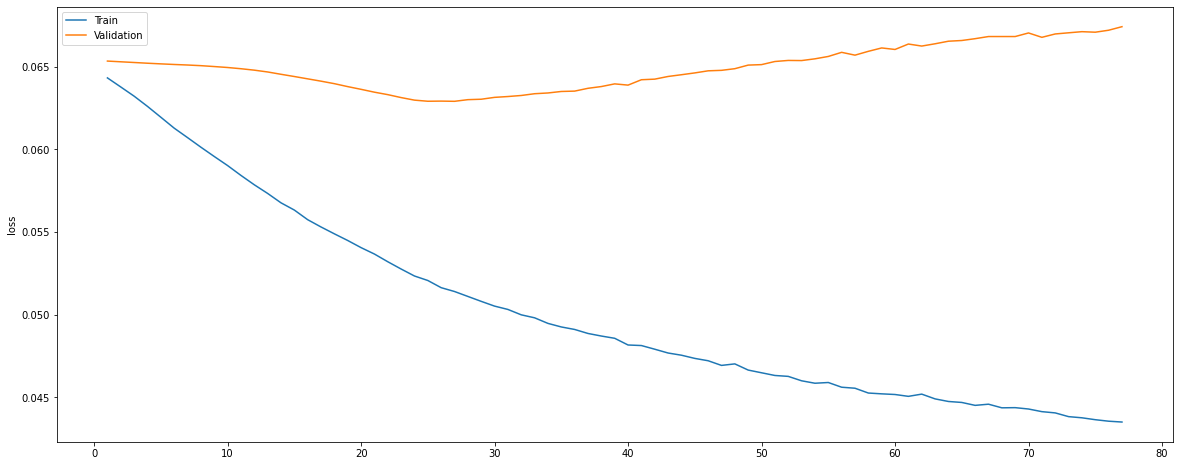

In [164]:
ModelInput = tf.keras.Input(
    shape=(NR_OF_PIXELS, BACKWARD_WINDOW_LENGTH))

aEncoderInputs = tf.keras.layers.Permute((2,1))(ModelInput)

aEncoderHiddens, aFinalH, aFinalC = tf.keras.layers.LSTM(300,
                                                         return_state = True, 
                                                         return_sequences = True,
                                                         name = 'Lstm_Encoder'
                                                        )(aEncoderInputs)
aFinalH = tf.keras.layers.BatchNormalization(name = 'Encoder_Final_Hidden_State_Batch_Norm')(aFinalH)
aFinalC = tf.keras.layers.BatchNormalization(name = 'Encoder_Final_Carry_State_Batch_Norm')(aFinalC)

aDecoderInputs = tf.keras.layers.RepeatVector(FORWARD_WINDOW_LENGTH)(aFinalH)

aDecoderHiddens = tf.keras.layers.LSTM(300, 
                       return_state = False, 
                       return_sequences = True
                      )(aDecoderInputs, initial_state=[aFinalH, aFinalC])

aAttentions = tf.keras.layers.dot([aDecoderHiddens, aEncoderHiddens], axes=[2, 2])
aAttentions = tf.keras.layers.Softmax()(aAttentions)

aContextVector = tf.keras.layers.dot([aAttentions, aEncoderHiddens], axes=[2,1])
aContextVector = tf.keras.layers.BatchNormalization()(aContextVector)
aContextVector = tf.keras.layers.concatenate([aContextVector, aDecoderHiddens])

aDecoderOutputs = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(150)
)(aContextVector)

aDecoderOutputs = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(150)
)(aDecoderOutputs)

aDecoderOutputs = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(NR_OF_PIXELS)
)(aDecoderOutputs)

aModelOutput = tf.keras.layers.Permute((2,1))(aDecoderOutputs)

aModelOutput = tf.keras.layers.Softmax(axis = 1)(aModelOutput)

oModel = tf.keras.Model(
    inputs=ModelInput,
    outputs=aModelOutput,
    name = 'LUONG_ATTENTION_MODEL'
)



oOptimizer = tf.keras.optimizers.Adam(learning_rate=2e-05)
oModel.compile(
    loss = tf.keras.losses.MeanAbsoluteError(), 
    optimizer=oOptimizer
)


print(oModel.summary())


# fit model
oEarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 50, 
    restore_best_weights = True)

oModel.fit(
    X_train, 
    Y_train, 
    epochs= 1000, 
    batch_size=2**8, 
    verbose=1, 
    validation_data= (X_validation, Y_validation),
    callbacks=[oEarlyStop]
)

# show epoch history
dfHistory = pd.DataFrame(oModel.history.history)

plt.figure(figsize = (20, 8))
sns.lineplot(data = dfHistory['loss'].iloc[1:], legend = True, label = 'Train')
sns.lineplot(data = dfHistory['val_loss'].iloc[1:], legend = True, label = 'Validation')
plt.show()

# # test model
# a_Y_datasets = [Y_train, Y_validation]
# a_X_datasets = [X_train, X_validation]
# a_labels = ['train', 'validation'] 

# plt.figure(figsize = (20,8 ))
# for X,Y, sLabel in list(zip(a_X_datasets, a_Y_datasets, a_labels)):
#     aActual = oScalerOutput.inverse_transform(Y)
#     aPred = oScalerOutput.inverse_transform(oModel.predict(X))

#     df = pd.DataFrame(data = np.column_stack((aActual,aPred)),
#                  columns = ['ACTUAL', 'PREDICTION']
#                 )
    
#     fR2Score = round(r2_score(aActual, aPred), 1)
#     sLabel = '{}   r2: {}'.format(sLabel,fR2Score)
#     sns.scatterplot(data = df, x = 'ACTUAL', y = 'PREDICTION', label = sLabel)
# plt.show()


# tf.keras.utils.plot_model(oModel,  show_shapes=True)

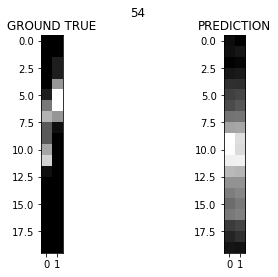

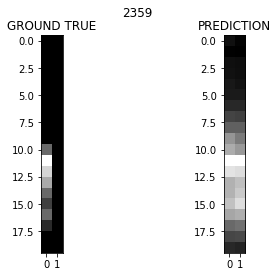

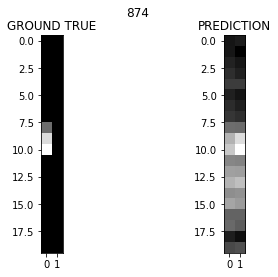

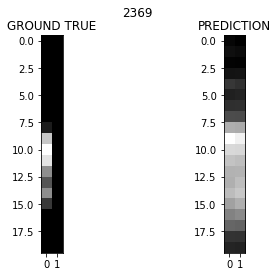

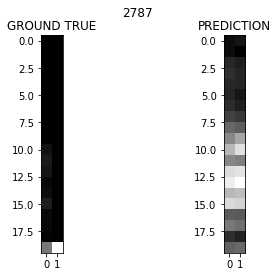

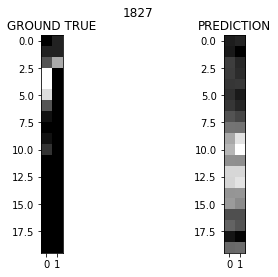

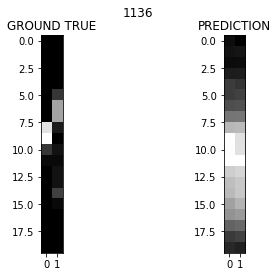

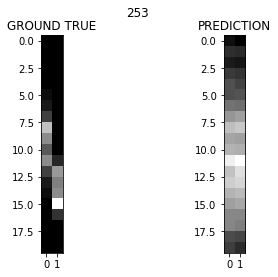

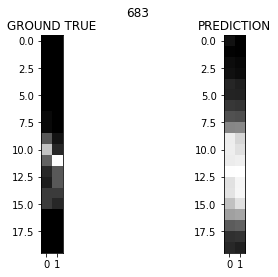

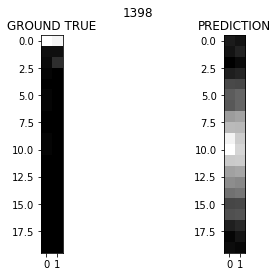

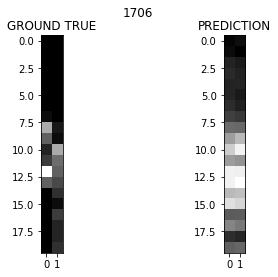

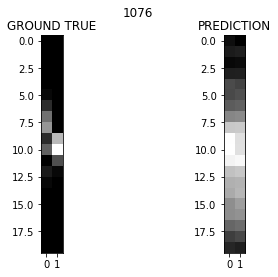

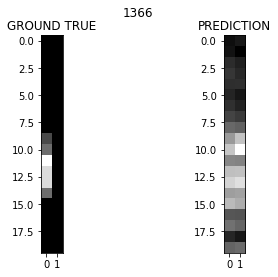

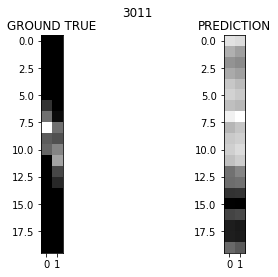

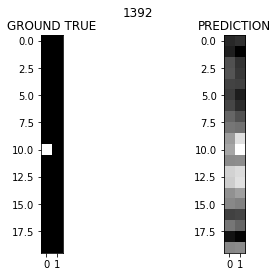

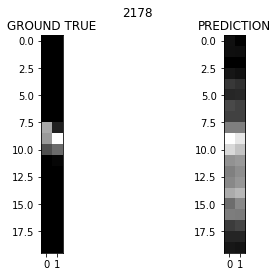

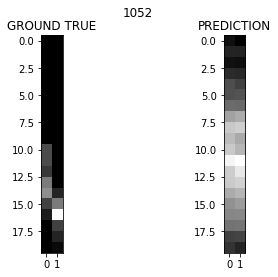

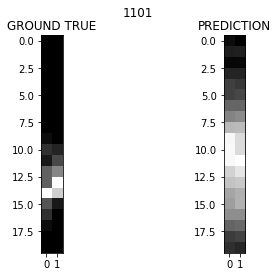

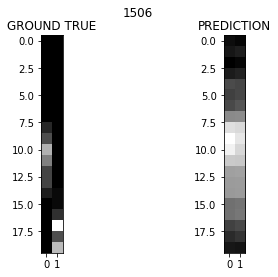

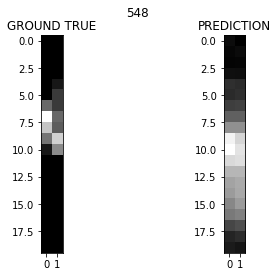

In [165]:
for i in np.random.randint(low = 0,high = len(X_train), size = 20):
    pred = oModel.predict(X_train)
    ground_true = Y_train 
    fig, axs = plt.subplots(1,2)
    fig.suptitle(i)
    
    axs[0].imshow(ground_true[i], cmap='gray')
    axs[0].set_title( 'GROUND TRUE')
    
    axs[1].imshow(pred[i], cmap='gray')
    axs[1].set_title( 'PREDICTION')